## KMeans Clustering​
K means clustering is one of the most popular clustering algorithms and usually the first thing practitioners apply when solving clustering tasks to get an idea of the structure of the dataset.

1. A cluster is the collection of objects which are “similar” between them and are “dissimilar” to the objects belonging to other clusters.​
2. k-means clustering is a method of vector quantization, originally from signal processing, that is popular for cluster analysis in data mining.​

### Data Ingestion ( 4 CSV file ) into sprak from dbfs

Due to Limitations of the filesize to upload on the databricks community edition, we had to split it into four files. Read all four files and merge them for a dataframe

In [0]:
# File location and type
file_location = "/FileStore/tables/car_prices__1.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df1 = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

df1.head()

Out[12]: Row(year='2015', make='Kia', model='Sorento', trim='LX', body='SUV', transmission='automatic', vin='5xyktca69fg566472', state='ca', condition='5', odometer='16639', color='white', interior='black', seller='kia motors america, inc', mmr='20500', sellingprice='21500', saledate='Tue Dec 16 2014 12:30:00 GMT-0800 (PST)')

In [0]:

# File location and type
file_location = "/FileStore/tables/car_prices_2.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "false"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df2 = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("sep", delimiter) \
  .load(file_location)

df2.head()

Out[13]: Row(_c0='2007', _c1='Toyota', _c2='Prius', _c3='Base', _c4='Hatchback', _c5='automatic', _c6='jtdkb20u273235378', _c7='nv', _c8='4.3', _c9='70211', _c10='gray', _c11='gray', _c12='michael hohl motor company', _c13='6850', _c14='10100', _c15='Fri Jan 16 2015 03:45:00 GMT-0800 (PST)')

In [0]:

# File location and type
file_location = "/FileStore/tables/car_prices_3.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "false"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df3 = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("sep", delimiter) \
  .load(file_location)

df3.head()

Out[14]: Row(_c0='2009', _c1='Chevrolet', _c2='Malibu', _c3='LS', _c4='Sedan', _c5='automatic', _c6='1g1zg57b39f134866', _c7='nc', _c8='2', _c9='146605', _c10='black', _c11='tan', _c12='barnett finance company', _c13='4100', _c14='3700', _c15='Tue Feb 10 2015 01:15:00 GMT-0800 (PST)')

In [0]:
# File location and type
file_location = "/FileStore/tables/car_prices_4.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "false"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df4 = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("sep", delimiter) \
  .load(file_location)

df4.head()

Out[15]: Row(_c0='2005', _c1='GMC', _c2='Canyon', _c3='Z85 SLE', _c4='Crew Cab', _c5='automatic', _c6='1gtds136058190201', _c7='ca', _c8='2.5', _c9='190330', _c10='white', _c11='gray', _c12='ecars', _c13='3550', _c14='5000', _c15='Tue May 19 2015 05:30:00 GMT-0700 (PDT)')

### Combine all the data into one Dataframe

In [0]:
df=df1.union(df2).union(df3).union(df4)
df.head()

Out[16]: Row(year='2015', make='Kia', model='Sorento', trim='LX', body='SUV', transmission='automatic', vin='5xyktca69fg566472', state='ca', condition='5', odometer='16639', color='white', interior='black', seller='kia motors america, inc', mmr='20500', sellingprice='21500', saledate='Tue Dec 16 2014 12:30:00 GMT-0800 (PST)')

Create table car_prices for analysis

In [0]:
# Create a view or table

temp_table_name = "car_prices"

df.createOrReplaceTempView(temp_table_name)

In [0]:
%sql

/* Query the created temp table in a SQL cell */

select count(*) from `car_prices`

count(1)
558837


In [0]:
# With this registered as a temp view, it will only be available to this particular notebook. If you'd like other users to be able to query this table, you can also create a table from the DataFrame.
# Once saved, this table will persist across cluster restarts as well as allow various users across different notebooks to query this data.
# To do so, choose your table name and uncomment the bottom line.

permanent_table_name = "car_prices"
  
#df.write.format("parquet").saveAsTable(permanent_table_name)

In [0]:
from pyspark.sql import SparkSession

In [0]:
# Selecting the dependent and the independent variables that are identified as most useful attributes to make predictions
data=df.select(['year','make','body','transmission','state','condition','odometer','color','interior'])

In [0]:
data=data.dropna()

### Building the K Means model
Data pre-processing

In [0]:
# Import the required libraries

from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler,StringIndexer
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt # for data visualization


In [0]:
# Use StringIndexer to convert the categorical columns to hold numerical data

year_indexer = StringIndexer(inputCol='year',outputCol='year_index',handleInvalid='keep')
make_indexer = StringIndexer(inputCol='make',outputCol='make_index',handleInvalid='keep')
body_indexer = StringIndexer(inputCol='body',outputCol='body_index',handleInvalid='keep')
transmission_indexer = StringIndexer(inputCol='transmission',outputCol='transmission_index',handleInvalid='keep')
state_indexer = StringIndexer(inputCol='state',outputCol='state_index',handleInvalid='keep')
condition_group_indexer = StringIndexer(inputCol='condition',outputCol='condition_index',handleInvalid='keep')
odometer_indexer = StringIndexer(inputCol='odometer',outputCol='odometer_index',handleInvalid='keep')
color_group_indexer = StringIndexer(inputCol='color',outputCol='color_group_index',handleInvalid='keep')
interior_indexer = StringIndexer(inputCol='interior',outputCol='interior_index',handleInvalid='keep')


In [0]:
# Vector assembler is used to create a vector of input features

assembler = VectorAssembler(inputCols=['year_index','make_index','body_index','transmission_index','state_index','condition_index',                                                                'odometer_index','color_group_index','interior_index'], outputCol="features")

In [0]:
# Pipeline is used to pass the data through indexer and assembler simultaneously. Also, it helps to pre-rocess the test data
# in the same way as that of the train data.

pipe = Pipeline(stages=[year_indexer,make_indexer,body_indexer,transmission_indexer,
                        state_indexer,condition_group_indexer,odometer_indexer,color_group_indexer,interior_indexer,assembler])

In [0]:
final_data=pipe.fit(data).transform(data)

Build the KMeans model for cluster size 8

In [0]:
# Create an object for the KMeans model

kmeans_model = KMeans(k=8)

In [0]:
fit_model = kmeans_model.fit(final_data)

Calculate the cost using Sum of Squared errors

In [0]:
wssse = fit_model.summary.trainingCost # for spark 3.0
print("The within set sum of squared error of the mode is {}".format(wssse))

The within set sum of squared error of the mode is 13937947502624.32


In [0]:
centers = fit_model.clusterCenters()

In [0]:
print("Cluster Centers")
index=1
for cluster in centers:
    print("Centroid {}: {}".format(index,cluster))
    index+=1


Cluster Centers
Centroid 1: [2.41636765e+00 6.84570889e+00 3.70070103e+00 2.95991726e-02
 6.45245362e+00 1.16606183e+01 1.76869327e+04 2.79151610e+00
 9.12364486e-01]
Centroid 2: [4.82052026e+00 7.60658221e+00 3.84503433e+00 3.75527834e-02
 7.03030010e+00 1.22133095e+01 4.82621685e+04 2.93134126e+00
 1.07128582e+00]
Centroid 3: [7.22744478e+00 8.25896624e+00 3.75434351e+00 4.19458923e-02
 7.18193100e+00 1.27839724e+01 1.14021576e+05 3.10368578e+00
 1.26492306e+00]
Centroid 4: [5.85651518e+00 7.56034891e+00 3.92924833e+00 4.32263623e-02
 7.01705794e+00 1.24317252e+01 9.05190000e+04 2.99048029e+00
 1.15321990e+00]
Centroid 5: [1.72905817e+00 6.65897773e+00 3.65890526e+00 2.65868784e-02
 6.16607481e+00 1.14464380e+01 5.10402472e+03 2.79124952e+00
 8.71341457e-01]
Centroid 6: [4.20899337e+00 7.44763788e+00 3.75850239e+00 3.76328088e-02
 6.95267018e+00 1.20860304e+01 6.75428448e+04 2.86854772e+00
 1.04094100e+00]
Centroid 7: [3.04936238e+00 6.95362530e+00 3.68537492e+00 3.22669970e-02
 6.65

Collect the results for the final data

In [0]:
# Store the results in a dataframe

results = fit_model.transform(final_data)

In [0]:
results.head()

Out[33]: Row(year='2015', make='Kia', body='SUV', transmission='automatic', state='ca', condition='5', odometer='16639', color='white', interior='black', year_index=12.0, make_index=8.0, body_index=1.0, transmission_index=0.0, state_index=1.0, condition_index=23.0, odometer_index=1178.0, color_group_index=1.0, interior_index=0.0, features=DenseVector([12.0, 8.0, 1.0, 0.0, 1.0, 23.0, 1178.0, 1.0, 0.0]), prediction=4)

In [0]:
results.select(['year_index','make_index','body_index','transmission_index','state_index','condition_index',                                                                'odometer_index','color_group_index','interior_index','prediction']).show()

+----------+----------+----------+------------------+-----------+---------------+--------------+-----------------+--------------+----------+
|year_index|make_index|body_index|transmission_index|state_index|condition_index|odometer_index|color_group_index|interior_index|prediction|
+----------+----------+----------+------------------+-----------+---------------+--------------+-----------------+--------------+----------+
|      12.0|       8.0|       1.0|               0.0|        1.0|           23.0|        1178.0|              1.0|           0.0|         4|
|      12.0|       8.0|       1.0|               0.0|        1.0|           23.0|       20819.0|              1.0|           2.0|         0|
|       2.0|       7.0|       0.0|               0.0|        1.0|           20.0|      117778.0|              3.0|           0.0|         2|
|      12.0|      26.0|       0.0|               0.0|        1.0|            7.0|       22471.0|              1.0|           0.0|         0|
|       2.0| 

In [0]:
results.groupby('prediction').count().sort('prediction').show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0|78416|
|         1|61963|
|         2|32047|
|         3|46480|
|         4|96876|
|         5|57048|
|         6|68629|
|         7|30991|
+----------+-----+



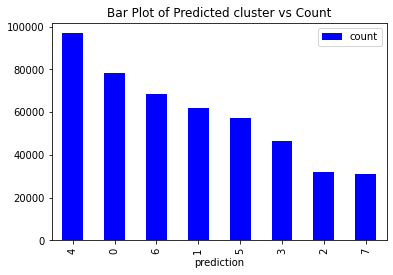

In [0]:
pred=results.select('prediction').na.drop(subset=["prediction"]).groupBy("prediction").count().sort("count",ascending=False)
#Converting into the Pandas Data Frame
pandasDFpred = pred.toPandas()


import matplotlib.pyplot as plt
# bar plot
pandasDFpred[:30].plot(kind = 'bar',x = 'prediction',
y = 'count',color = 'blue')
# set the title
plt.title('Bar Plot of Predicted cluster vs Count')
# show the plot
plt.show()


In [0]:
from math import sqrt
def error(point):
    center = fit_model.centers[model.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

In [0]:
data_pandas=data.toPandas()

In [0]:
data_pandas.head()

,year,make,body,transmission,state,condition,odometer,color,interior
0,2015,Kia,SUV,automatic,ca,5,16639,white,black
1,2015,Kia,SUV,automatic,ca,5,9393,white,beige
2,2014,BMW,Sedan,automatic,ca,4.5,1331,gray,black
3,2015,Volvo,Sedan,automatic,ca,4.1,14282,white,black
4,2014,BMW,Sedan,automatic,ca,4.3,2641,gray,black


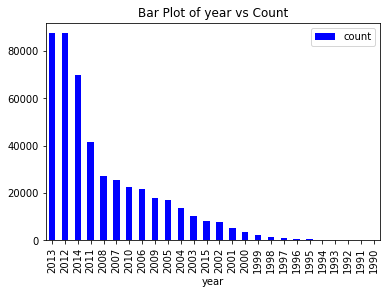

In [0]:
sortdata1=data.select('year').na.drop(subset=["year"]).groupBy("year").count().sort("count",ascending=False)
#Converting into the Pandas Data Frame
pandasDF1 = sortdata1.toPandas()


import matplotlib.pyplot as plt
# bar plot
pandasDF1[:30].plot(kind = 'bar',x = 'year',
y = 'count',color = 'blue')
# set the title
plt.title('Bar Plot of year vs Count')
# show the plot
plt.show()



In [0]:
sortdata2=data.select('make').na.drop(subset=["make"]).groupBy("make").count().sort("count",ascending=False)
sortdata2.show()

+-------------+-----+
|         make|count|
+-------------+-----+
|         Ford|81014|
|    Chevrolet|54150|
|       Nissan|44043|
|       Toyota|35313|
|        Dodge|27183|
|        Honda|24781|
|      Hyundai|18663|
|          BMW|17589|
|          Kia|15830|
|     Chrysler|15135|
|     Infiniti|14011|
|Mercedes-Benz|14008|
|         Jeep|12735|
|   Volkswagen|10806|
|        Lexus|10409|
|          GMC| 9217|
|        Mazda| 6930|
|     Cadillac| 6315|
|      Lincoln| 4926|
|         Audi| 4810|
+-------------+-----+
only showing top 20 rows



In [0]:
#Converting into the Pandas Data Frame
pandasDF2 = sortdata2.toPandas()
print(pandasDF2[:20])


             make  count
0            Ford  81014
1       Chevrolet  54150
2          Nissan  44043
3          Toyota  35313
4           Dodge  27183
5           Honda  24781
6         Hyundai  18663
7             BMW  17589
8             Kia  15830
9        Chrysler  15135
10       Infiniti  14011
11  Mercedes-Benz  14008
12           Jeep  12735
13     Volkswagen  10806
14          Lexus  10409
15            GMC   9217
16          Mazda   6930
17       Cadillac   6315
18        Lincoln   4926
19           Audi   4810


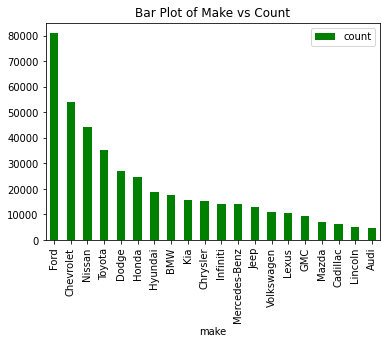

In [0]:
import matplotlib.pyplot as plt
# bar plot
pandasDF2[:20].plot(kind = 'bar',x = 'make',
y = 'count',color = 'green')
# set the title
plt.title('Bar Plot of Make vs Count')
# show the plot
plt.show()

In [0]:
results_pandas=results.select(['year_index','make_index','body_index','transmission_index','state_index','condition_index',                                                                'odometer_index','color_group_index','interior_index','prediction'])

In [0]:
results_pandas.toPandas()

,year_index,make_index,body_index,transmission_index,state_index,condition_index,odometer_index,color_group_index,interior_index,prediction
0,12.0,8.0,1.0,0.0,1.0,23.0,1178.0,1.0,0.0,4
1,12.0,8.0,1.0,0.0,1.0,23.0,20819.0,1.0,2.0,0
2,2.0,7.0,0.0,0.0,1.0,20.0,117778.0,3.0,0.0,2
3,12.0,26.0,0.0,0.0,1.0,7.0,22471.0,1.0,0.0,0
4,2.0,7.0,0.0,0.0,1.0,4.0,57892.0,3.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
472445,3.0,7.0,0.0,0.0,0.0,8.0,44353.0,1.0,5.0,1
472446,1.0,23.0,8.0,0.0,18.0,23.0,62387.0,1.0,0.0,5
472447,1.0,7.0,1.0,0.0,1.0,18.0,41310.0,0.0,0.0,1
472448,12.0,2.0,2.0,0.0,3.0,13.0,22954.0,1.0,0.0,0


Evaluate the results using Clustering Evaluator to find the Silhoutte Score Coefficient.
Silhouette Coefficient or silhouette score is a metric used to calculate the goodness of a clustering technique. Its value ranges from -1 to 1.​

1: Means clusters are well apart from each other and clearly distinguished.​

0: Means clusters are indifferent, or we can say that the distance between clusters is not significant.​

-1: Means clusters are assigned in the wrong way.​

In [0]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(k=i)
    KMeans_fit=KMeans_algo.fit(final_data)
    output=KMeans_fit.transform(final_data)
    score=evaluator.evaluate(output)
    silhouette_score.append(score)
    print("Silhouette Score:",score)

Silhouette Score: 0.8013862497298677
Silhouette Score: 0.7607869974974666
Silhouette Score: 0.748508803342542
Silhouette Score: 0.7475523563728841
Silhouette Score: 0.7268709468115478
Silhouette Score: 0.7235824754287261
Silhouette Score: 0.7099820557736435
Silhouette Score: 0.7160013769923725


Out[47]: Text(0, 0.5, 'cost')

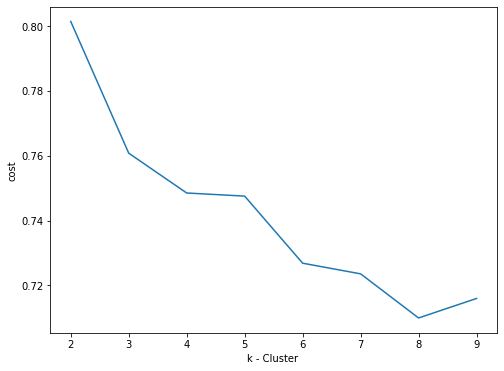

In [0]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k - Cluster ')
ax.set_ylabel('cost')